# Finite-size corrections to charged defect supercells with FHI-aims

## 1. Introduction

This tutorial notebook is designed for applying finite-size corrections for charged defects when using the supercell method and outputs from the all-electron electronic structure software package [FHI-aims](https://aimsclub.fhi-berlin.mpg.de/). This notebook provides a step-by-step explanation of all that is involved in the processing of the defect data when applying the correction scheme utilised in this workflow as the notebook progresses.

This notebook can be run to perform corrections for one defect at a time. If the user has a large set of defect calculations to process, another script has been made available called DefectCorrectionsDataset.py. This uses the [NotebookScripter](https://github.com/breathe/NotebookScripter) library to run this notebook over a set of defect calculations from the terminal. However, it is advisable to first step through the workflow in this notebook to be aware of the steps and assumptions made during the processing of the data. Outputs generated by this workflow are stored in a directory 'ProcessedDefects' in the same directory as this notebook.

### Background reading

For background reading on electronic structure calculations for defects in solids, doi: 10.1103/RevModPhys.86.253 provides a thorough review on the topic where it is the 'supercell approach' that is utilised in this workflow. Other important background reading includes doi: 10.1088/0965-0393/17/8/084002, doi: 10.1103/PhysRevLett.102.016402, doi: 10.1016/j.cpc.2018.01.011 and doi: 10.1103/PhysRevB.89.195205. Methods described in all of these works are relevant for this workflow.

### Calculating the formation energy of charged defect supercells
The formation energy of a charged defect is given by:

$ \Delta H_{D,q} = [E_{D,q} + E^{corr}_{q}] - E_{host} + \sum_i n_i (E_i + \mu_i) + q[\epsilon_F + \epsilon_{\nu} + \Delta \nu_{0/b}] $

Where $E_{D,q}$ is the total energy for a defect in charge state q embedded in a supercell from electronic structure calculations, $E^{corr}_{q}$ are finite-size corrections to this defect supercell, $E_{host}$ is the calculated total energy of an equivalent perfect host lattice supercell, $n_i$ is the number of atoms of species i added to ($n_i > 0 $) or removed from ($n_i < 0$) the chemical reservoir when the defect is formed. $\mu_i$ is the chemical potential of species i, referenced to the total energy of the pure element in its standard state, $E_i$, $\epsilon_F$ is the position of the Fermi level in the band gap,  $q \epsilon_{\nu}$ (energy of bulk VBM) and $\Delta \nu_{0/b}$ (term used to align the electrostatic potential of the VBM for the bulk and defect supercells). Please refer to papers listed in the 'background reading' section for more details.

In this workflow, it is possible to obtain the $E^{corr}_{q}$ term for a charged defect in periodic DFT calculations with anisotropic dielectric screening from the host lattice with either the LZ (doi: 10.1088/0965-0393/17/8/084002) or FNV (doi: 10.1103/PhysRevLett.102.016402) finite-size correction schemes. The FNV scheme is implemented here by using the CoFFEE python code (doi: 10.1016/j.cpc.2018.01.011). Currently, band filling corrections to $E^{corr}_{q}$ (descriptions of which can be found in in doi: 10.1103/physrevb.72.035211, 10.1103/PhysRevB.78.235104 and 10.1088/0965-0393/17/8/084002) that are most relevant for shallow defects with delocalised defect-induced charge, are not currently available in this workflow. 

The potential alignment step (towards the end of the workflow) to obtain $\Delta \nu_{0/b}$ uses averaged atom-site potentials with the sampling region proposed by Kumagai and Oba (doi: 10.1103/PhysRevB.89.195205), see Fig. 2(a) in the publication.

## 2. Assumptions

### Necessary data

1. Components of the static dielectric tensor of the host crystal (calculated electronic + ionic contributions). This must be added to the user inputs cell. It is best to use computed values for dielectric constants for consistent corrections.

2. Relaxed structures for charged defect supercells, neutral defect supercells and equivalent perfect supercell. (Supercells have all been relaxed and then a single one-shot is performed where control.in tags for geometry relaxation have been removed or commented out and the tag for atom site potentials has been included `output on-site esp`). *** Maybe add tag for planar av too if this is used in final workflow?? ***

### Defect supercells

1. The **VOLUME** of the supercells has **NOT** been relaxed so lattice vectors are the same for the perfect and defect supercells (this is appropriate for simulating defects in the dilute limit).

2. DFT data being processed is for **INTRINSIC** defects only (there are no atom types present in the defect supercell that are not also present in the perfect supercell).

3. A maximum of one point defect is present in each supercell.

4. When vacancies are created in the supercell, the line for the vacancy site has been removed (not just commented out).

5. The supercells have orthogonal axes for the lattice vectors (a small amount of numerical noise in the off-diagonals is okay).

The above assumptions are necessary for the methods used to locate the defects in this workflow using functions in DefectSupercellAnalyses.py.


### Format of data

1. All output filenames from FHI-aims calculations still have their original default names: 'geometry.in' and 'On-site_ESP.dat'. *** Add planar av file from FHI-aims depending on pa methods used in final version ***

2. The data from all final one-shot calculations of the perfect and defect supercells are stored in one directory. Sub-directories for the different defects within this directory are fine (will be searched through by this notebook) and are to be expected to keep data organised!

3. As no relaxation steps were performed on the final structures, the only geometry files in these directories should be 'geometry.in' files (i.e. no 'geometry.in.next_step' files) and these correspond to the final relaxed structure for each supercell. 


### Charge model for FNV scheme

See CoFFEE paper (doi: 10.1016/j.cpc.2018.01.011) and later cells in this notebook for more details on the role of the Gaussian charge model used in the correction scheme. Assumptions made in this workflow:

1. The same sigma value is used for the Gaussian charge model implemented in the CoFFEE package for all defects in the same set for consistency. The maximum sigma is assumed to be the minimum distance of all defects in the set to the supercell boundary, but note that in reality the charge associated with some defects may be more or less disperse than others.

2. This workflow sets the cutoff for the plane waves used in CoFFEE's Poisson solver. Smaller sigma values require more plane waves to achieve convergence and the more plane waves the slower the solver will be. If it turns out that you are unable to achieve convergence with the cutoff value set in the notebook based on sigma, there is also the option to override the value and set this manually. This is the 'manual_cutoff' variable in the user inputs cell. Tests so far have not shown this to be necessary.
3. This workflow does not currently include band filling corrections. It is assumed that the charge associated with a defect is contained within the supercell.

## 3. Getting setup for the workflow
First download a copy of the repository. All analysis should be performed from the directory containing the notebook file (DefectCorrectionsNotebook.ipynb).

This workflow uses python3. The most convenient way to setup the python environment for this workflow is to use [Anaconda](https://www.anaconda.com/distribution/). All dependencies present when testing this workflow are listed in DefectCorrections_conda_env.yml. This environment can be re-created using conda with 

`conda env create -n chooseYourEnvName --file DefectCorrections_conda_env.yml` 

To use this workflow you must then activate this conda environment with 

`conda activate YourChosenEnvName`

The package used for applying the FNV correction scheme in this workflow (CoFFEE version 1.1) can be downloaded from [here](https://www.sciencedirect.com/science/article/pii/S0010465518300158). All dependencies required for this version of CoFFEE were contained in the conda environment above and instructions in the CoFFEE README just required the user to go to the downloaded CoFFEE folder and run 

`python setup.py build_ext -b PoissonSolver/`

All user defined settings are in the first cell. All subsequent cells do not require user inputs. They just need to be run in order and there is an explanation of the analysis being performed before each cell. Note that some cells will take longer to run than others. Each charged defect needs to be processed one at a time by specifying the location of directories with the relevant data in the 'User inputs' cell. To run this analysis for a full set of defects data, this information can be inputted as arguments in the DefectCorrectionsDataset.py script. Additional instructions are contained in DefectCorrectionsDataset.py.

## 4. User inputs
The cell below is the only cell that must be modified by the user before running the notebook. This cell is replaced by an argument list when processing a set of defects with DefectCorrectionsDataset.py (using the [NotebookScripter](https://github.com/breathe/NotebookScripter) library).

In [1]:
# Put here to allow notebook to be run externally for full defect dataset without stalls from interactive plots
%matplotlib inline 
# Function used to allow user inputs in notebook to be overwritten when running over full dataset
from NotebookScripter import receive_parameter


### USER INPUTS START BELOW HERE ###

# Dielectric properties of host crystal: electronic+ionic dielectric constants
dielectric_xx = receive_parameter(dielectric_xx = 7.49)
dielectric_yy = receive_parameter(dielectric_yy = 6.92)
dielectric_zz = receive_parameter(dielectric_zz = 7.19)

# Outputs from FHI-aims calculation: dir with all data for final one-shots of all defect supercells (inc. perfect supercell)
path_to_all_defects = receive_parameter(path_to_all_defects = '/Users/suzannewallace/PhD/git_repos/DefectCorrectionsNotebook/tests/TestData') 
# Outputs from FHI-aims calculation: dir with data for perfect host supercell
path_to_host = receive_parameter(path_to_host = '/Users/suzannewallace/PhD/git_repos/DefectCorrectionsNotebook/tests/TestData/perfect') 
# Choose name for directory (dir) to store output files for defect currently being processed
defect_outputs_dir = receive_parameter(defect_outputs_dir = 'interstitial_test')
# Outputs from FHI-aims calculation: dir with defect you want to perform correction for
path_to_defect = receive_parameter(path_to_defect = '/Users/suzannewallace/PhD/git_repos/DefectCorrectionsNotebook/tests/TestData/interstitial')
# Outputs from FHI-aims calculation: dir with neutral version of defect you want to correct
path_to_neutral = receive_parameter(path_to_neutral = '/Users/suzannewallace/PhD/git_repos/DefectCorrectionsNotebook/tests/TestData/interstitial')
# Enter charge state of defect you want to perform the correction for
defect_charge = receive_parameter(defect_charge = 1)

# Choose names for files for outputs for correction steps, these wil be stored in specified defect_outputs_dir
charge_model_file = receive_parameter(charge_model_file = 'charge_model.dat') #File containing coffee.py outputs for charge models of increasing size
pa_plot_file = receive_parameter(pa_plot_file = 'pa_plot.png') #Name for plot for potential alignment plot for this defect

# Plane wave cutoff for Poisson solver will be computed based on sigma value of Gaussian charge model
# If this is found to not converge after running the script, option below to manually set the cutoff (e.g. 40.0)
# Leave as None to let the script use the value computed based on the sigma value of the Gaussian charge model
manual_cutoff = receive_parameter(manual_cutoff = None)

### END OF USER INPUTS ###

## 5. Python libraries used in the workflow

In [2]:
import re
import glob
import subprocess
import os
import string
import numpy as np
from numpy import dot,cross,pi
from scipy.interpolate import spline
from shutil import copyfile
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.core.pylabtools import figsize
# Custom functions for workflow
import LogFileSetup as lfs
import DefectSupercellAnalyses as dsa
import CoffeeConvenienceFunctions as ccf

## 6. Setting up log file and outputs directory

In [3]:
# Make directory for outputs from processing of this defect
defect_outputs_dir = os.path.join("ProcessedDefects", defect_outputs_dir)
os.makedirs(defect_outputs_dir, exist_ok=True)

# Initialise log file
logger = lfs.configure_logging(os.path.join(defect_outputs_dir, "log"))

## 7. Reading information for the perfect host crystal supercell
It has been assumed that the volume of defect supercells has not been relaxed, therefore the lattice vectors of the perfect host supercell are the same as those of the defect supercells.

In [4]:
# Read in geometry information for perfect host crystal
host_geom = os.path.join(path_to_host, 'geometry.in')
host_coords = dsa.read_atom_coords(host_geom)
# Read in supercell dimensions from perfect crystal (should be same for defect supercells if volume fixed)
supercell_dims = dsa.get_supercell_dimensions(host_geom)

## 8. Locating the defect coordinates
This script locates the coordinates of the defect by comparing the defect supercell to the perfect host supercell and using the functions defined in DefectSupercellAnalyses.py.
The defect position is referenced to the species that would be in the perfect host in the case of a vacancy, e.g. the S atom removed from the host to make a S vacancy. The position is referenced to the atom added to the defect supercell in the case of an intersitial or antisite.

These coordinates will be used to define the centre of the Gaussian used in the charge model for the FNV method in the input 'in' file used with the Poisson solver in coffee.py. The z-position of the defect will also be used when generating plots for the potential alignment (pa) correction step towards the end of this workflow.

In [5]:
defect_geom = os.path.join(path_to_defect, 'geometry.in')
defect_coords = dsa.read_atom_coords(defect_geom)

defect_type = dsa.find_defect_type(host_coords, defect_coords)
if (defect_type == 'vacancy'):
    species_vac, defect_x, defect_y, defect_z = dsa.vacancy_coords(host_coords, defect_coords)
    logger.info('Defect is a '+str(species_vac)+' vacancy with charge '+str(defect_charge))
    logger.info('Defect coordinates in host supercell (Angstroms): '+str(defect_x)+', '+str(defect_y)+', '+str(defect_z))
elif (defect_type == 'interstitial'):
    species_int, defect_x, defect_y, defect_z = dsa.interstitial_coords(host_coords, defect_coords)
    logger.info('Defect is a '+str(species_int)+' interstitial with charge '+str(defect_charge))
    logger.info('Defect coordinates in defect supercell (Angstroms): '+str(defect_x)+', '+str(defect_y)+', '+str(defect_z))
elif (defect_type == 'antisite'):
    species_in, species_out, defect_x, defect_y, defect_z = dsa.antisite_coords(host_coords, defect_coords)
    logger.info('Defect is a '+str(species_in)+'-on-'+str(species_out)+' antisite with charge '+str(defect_charge))
    logger.info('Defect coordinates in defect supercell (Angstroms): '+str(defect_x)+', '+str(defect_y)+', '+str(defect_z))
else:
    logger.info("Error identifying defect type")

[INFO] [Cell line num: 11] Defect is a Cu interstitial with charge 1
[INFO] [Cell line num: 12] Defect coordinates in defect supercell (Angstroms): 5.6, 2.6, 4.6


### 8.1. Finding smallest distances of the defect from the supercell boundary
In the script below the minimum distance of the defect to the supercell boundary is computed. In the plot of the defect supercell, the volume of the region used to represent the defect location is arbitrary and not representative of atom size.

[INFO] [Cell line num: 2] Nearest defect distances to supercell boundaries (Angstroms): 5.6, 2.6, 4.6


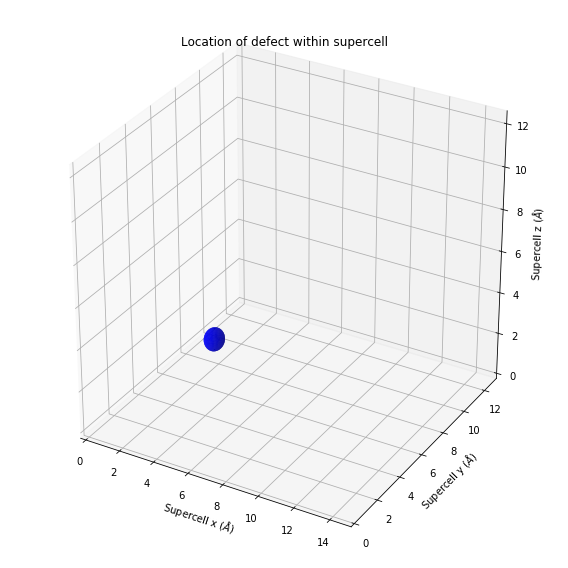

In [6]:
min_x, min_y, min_z = dsa.defect_to_boundary(defect_x, defect_y, defect_z, supercell_dims[0], supercell_dims[1], supercell_dims[2])
logger.info("Nearest defect distances to supercell boundaries (Angstroms): "+str(min_x)+", "+str(min_y)+", "+str(min_z))

figsize(8, 8)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
# Radius of sphere is sigma of Gaussian charge model converted back into Angstroms
x = 0.5 * np.outer(np.cos(u), np.sin(v)) + defect_x
y = 0.5 * np.outer(np.sin(u), np.sin(v)) + defect_y
z = 0.5 * np.outer(np.ones(np.size(u)), np.cos(v)) + defect_z

ax.plot_surface(x, y, z, color='b')
ax.set_xlim3d(0,supercell_dims[0])
ax.set_ylim3d(0,supercell_dims[1])
ax.set_zlim3d(0,supercell_dims[2])
ax.set_xlabel('Supercell x ($\AA$)')
ax.set_ylabel('Supercell y ($\AA$)')
ax.set_zlabel('Supercell z ($\AA$)')
plt.title('Location of defect within supercell')
plt.tight_layout()
plt.savefig(os.path.join(defect_outputs_dir, "defect_location.png"))

plt.show(block=False)

## 9. Obtain $E^{corr}_{q}$ from LZ finite-size correction scheme

The $E^{corr}_q$ term for the defect formation energy is first obtained in this workflow using the LZ correction scheme (see doi: 10.1088/0965-0393/17/8/084002 and doi: 10.1016/j.commatsci.2016.12.040 for more information). Here it is just the 'image-charge correction' that is being applied first and is denoted as $E^{corr}_q$, while sometimes in the literature $E^{corr}_q$ is used to refer to this correction and the potential alignment that is performed towards the end of this workflow. To avoid confusion with the term calculated next with the FNV scheme, $E^{corr, LZ}_q$ is how this term will be denoted in this workflow. Within the LZ scheme, this correction term is given by:


$ E^{corr, LZ}_q = [ 1 + c_{sh}(1- \frac{1}{\epsilon}) ] \frac{q^2 \alpha_M}{2 \epsilon L} $


Where $L = \Omega^{\frac{-1}{3}}$ is the linear supercell dimension, which has volume $\Omega$, $\epsilon$ is the calculated static dielectric constant inputed in the 'user inputs' cell, $\alpha_M$ is the Madelung constant and $c_{sh}$ is the shape factor. This terms are related to the supercell geometry.


*** Need to tabulate shape factors for each supercell type and add defining this to user inputs cell ?? ***

In [7]:
# Check with Tong for this step


## 10. Obtain $E^{corr}_{q}$ from FNV finite-size correction scheme

The finite-size electrostatic correction term from the FNV correction scheme is given by:
$ E^{corr}_{q} = E_{q}^{lat} - q\Delta V_{q-0/m} $

$E_{q}^{lat}$ is obtained from a Gaussian charge model and the next term is determined later in this workflow through a 'potential alignment' procedure which compares the model potential to the difference in potentials for the defect in a charged and neutral states from the electronic structure calculations. This will be discussed more in later cells when this procedure is applied.

### 10.1. Determining sigma for the Gaussian charge models for the defect set

This workflow uses the CoFFEE software package when implementing the FNV correction scheme (doi: 10.1103/PhysRevLett.102.016402) for finite-size corrections to charged defect supercells. This correction scheme involves solving the Poisson equation for a charge model system and aligning potentials to derive the correction to the formation energy. The model system used to simulate defect charge interactions with periodic images is a Gaussian within a periodicly repeated supercell where the calculated dielectric constant of the host lattice is used to represent the dielectric screening of the host lattice to the defect charge. The schematic below shows a charge model used to simulate the interaction between the defect charge in the central supercell and some of its periodic images. For more details on the charge model used when performing corrections to charged defect supercells with the scheme used in this workflow, please refer to the CoFFEE paper (doi: 10.1016/j.cpc.2018.01.011).

<img src="figures/charge_model_schematic.png" width="200">

The purpose here is to determine the value of sigma for the Gaussian charge model that is small enough to ensure that the charge is contained within the supercell for all supercells in the defect set, including the ones where the defect is closest to the boundary of the supercell. For consistency, the same value of sigma is used for all defects in the set of calculations. As stated in the CoFFEE paper (doi: 10.1016/j.cpc.2018.01.011): 'For bulk systems, it is not necessary that the width of the Gaussian model charge match the defect wavefunction charge density. It suffices if the width is appropriately small to keep the model charge inside the cell.' As already mentioned, band-filling corrections are not currently applied in this workflow.

**This step needs to only be run once for your set of defects, so if it turns out to be slow for a large set of defects just run it once and for subsequent runs replace the cell below with a cell that just contains:**

`sigma = computed_value_from_first_run`

However, tests so far have not shown this to be necessary.

In [8]:
# Determining min distance of any defect to supercell boundary in set of defects
all_distances_to_boundaries = []
for geom_file in glob.glob(os.path.join(path_to_all_defects,'**/geometry.in'), recursive=True):
    if not os.path.samefile(geom_file, host_geom):
        defect_coords = dsa.read_atom_coords(geom_file)
        defect_type = dsa.find_defect_type(host_coords, defect_coords)
        if (defect_type == 'vacancy'):
            species_vac, defect_x, defect_y, defect_z = dsa.vacancy_coords(host_coords, defect_coords)
        elif (defect_type == 'interstitial'):
            species_int, defect_x, defect_y, defect_z = dsa.interstitial_coords(host_coords, defect_coords)
        elif (defect_type == 'antisite'):
            species_in, species_out, defect_x, defect_y, defect_z = dsa.antisite_coords(host_coords, defect_coords)
        else:
            logger.info("Error identifying defect type in "+str(geom_file))
        all_distances_to_boundaries.append(min(dsa.defect_to_boundary(defect_x, defect_y, defect_z, supercell_dims[0], supercell_dims[1], supercell_dims[2])))

closest_defect_to_boundary = abs(min(all_distances_to_boundaries))
# Define sigma for Gaussian as a 10% less than closest defect distance to boundary in dataset (in Angstroms)
sigma = closest_defect_to_boundary-(0.1*closest_defect_to_boundary)
logger.info("Sigma used for Gaussian charge model = "+str(sigma))

[INFO] [Cell line num: 20] Sigma used for Gaussian charge model = 2.108966292


In [9]:
# sigma = computed_value_from_first_run

### 10.2. Determining cutoff for Poisson solver based on sigma of Gaussian charge model

The script below sets the cutoff for the plane waves used in CoFFEE's Poisson solver. Smaller sigma values require more plane waves to achieve convergence and the more plane waves the slower the solver will be. 

If it turns out that you are unable to achieve convergence with the cutoff value set based on sigma, there is also the option to override the value and set this manually. This is the 'manual_cutoff' variable in the user inputs cell. Tests so far have not shown this to be necessary.

In [10]:
# Script to compute plane wave cutoff based on sigma (20.0 Hartree was fine for sigma=1.4)
cutoff_ratio = 20.0/1.4 # Found to converge well in tests
cutoff = cutoff_ratio/sigma

# Override computed value if user has set a manual cutoff
cutoff = manual_cutoff if manual_cutoff else cutoff

### 10.3. Determine $E_{q}^{lat}$ from the Gaussian charge model

The CoFFEE software package has been developed to be compatible with 1D, 2D and 3D systems. The long range model potential for bulk (3D) systems can be analytically derived, but in the case of spatially varying dielectric profiles (in 1D and 2D systems) it is practical to solve the Poisson equation numerically and extrapolate the electrostatic energy to the isolated limit $E_q^{iso,m}$. Although this workflow is for 3D defect supercells, it follows the general formalism in the CoFFEE workflow that is applicable to 1D, 2D and 3D systems. Therefore, the electrostatic energy is determined for a supercell that is the same size as that used in the electronic structure calculations with FHI-aims (this is denoted by $E_q^{per,m}$) and also for 2x2x2 and 3x3x3 supercells ($E_q^{per,2m}$ and $E_q^{per,3m}$ respectively) of that supercell to allow $E_q^{iso,m}$ to be determined by extrapolating the fit to the energies for the three supercell sizes. $E_q^{lat}$ is then obtained from the equation below.

$E_q^{lat} = E_q^{iso,m} - E_q^{per,m}$

See the [CoFFEE](https://www.sciencedirect.com/science/article/pii/S0010465518300158) paper for more details.


### 10.3.1. Run coffee.py Possion solver for charge models 
This is used to obtain $E_q^{per,m}$ for the charge model that is the same size as the supercell used in the DFT defect calculation and also to calculate $E_q^{per,2m}$ and $E_q^{per,3m}$ for 2x2x2 and 3x3x3 supercells of the DFT supercell.

The values computed for all three supercells will be used in step 10b to obtain $E_q^{iso,m}$ for the charge model from a fit to the three data points and extrapolating to the limit of an infinite supercell.

**Note: The cell below may take a while to run**

In [11]:
## Charge model for 3x3x3 supercell of the supercell used in DFT calculations, use to obtain E_q^{per,3m}
ccf.run_CoFFEE_solver("coffee.py", defect_outputs_dir, 3, 3, 3, defect_geom, sigma, cutoff, defect_charge, defect_x, defect_y, defect_z, dielectric_xx, dielectric_yy, dielectric_zz)
## Charge model for 2x2x2 supercell of the supercell used in DFT calculations, use to obtain E_q^{per,3m}
ccf.run_CoFFEE_solver("coffee.py", defect_outputs_dir, 2, 2, 2, defect_geom, sigma, cutoff, defect_charge, defect_x, defect_y, defect_z, dielectric_xx, dielectric_yy, dielectric_zz)

# The 1x1x1 supercell (i.e. same as original defect supercell size) is run last 
# This is to ensure V_r.npy left in the directory is for this system for subsequent analysis
# Charge model for same size supercell as used in DFT calculations, use to obtain E_q^{per,m}
ccf.run_CoFFEE_solver("./coffee.py", defect_outputs_dir, 1, 1, 1, defect_geom, sigma, cutoff, defect_charge, defect_x, defect_y, defect_z, dielectric_xx, dielectric_yy, dielectric_zz)
    
copyfile("V_r.npy", os.path.join(defect_outputs_dir,"V_r.npy"))

'ProcessedDefects/interstitial_test/V_r.npy'

In [12]:
# Do python re equivalent of (grep ! ${charge_model_file}) to get E_q^per,m from output
E_q_per_m = []
for dim in range (1,4,1):
    try:
        with open(os.path.join(defect_outputs_dir,"cm_"+str(dim)+"x"+str(dim)+"x"+str(dim)+".out"), 'r') as f:
            for line in f:
                if re.search('!', line):
                    words = line.split()
                    E_q_per_m.append(float(words[4]))
                    if line == None:
                        logger.info('Warning! - Error finding E_q^{per,m} from '+str(os.path.join(defect_outputs_dir,"cm_"+str(dim)+"x"+str(dim)+"x"+str(dim)+".out")))
                        logger.info('coffee.py may still be calculating E_q^{per,m}, check inside file: '+str(os.path.join(defect_outputs_dir,"cm_"+str(dim)+"x"+str(dim)+"x"+str(dim)+".out")))
    except IOError:
        logger.info("Could not open "+str(os.path.join(defect_outputs_dir,"cm_"+str(dim)+"x"+str(dim)+"x"+str(dim)+".out")))   
# E_q_per_m, E_q_per_2m, E_q_per_3m
logger.info("E_q_per_m = "+str(E_q_per_m[0])+", E_q_per_2m = "+str(E_q_per_m[1])+", E_q_per_3m = "+str(E_q_per_m[2]))
# Input these into coffee script below to obtain E_iso

[INFO] [Cell line num: 16] E_q_per_m = 0.3009, E_q_per_2m = 0.4008, E_q_per_3m = 0.4355


### 10.3.2. Obtain $E_q^{iso}$ from fit to $E_q^{per,m}$ for defect supercell, 2x2x2  and 3x3x3 of this supercell
Below is a plotting script adapted from plot_fit.py from the CoFFEE_1.1 'Examples' directory. It uses a fit to $E_q^{per,m}$, $E_q^{per,2m}$, $E_q^{per,3m}$ to extrapolate to the infinite supercell limit to get obtain $E_q^{iso,m}$.

$E_q^{iso,m}$ from this fit is used after to compute $E_q^{lat}$.

[INFO] [Cell line num: 35] E_m_iso from extrapolation = 0.5058545454545456


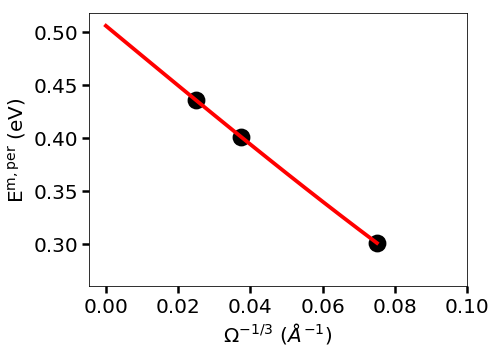

In [13]:
figsize(7, 5)

def compute_fit(C_u,L2,L3,L4):
    '''
    Computes the fitting polynomial.
    C_u takes the 3 model energies
    L2, L3 and L4 are 1/\Omega^{1/3} for the corresponding cells.
    '''
    A = np.array([[ L2, L2**3, 1.], [  L3, L3**3, 1.] , [  L4, L4**3, 1. ] ])
    A_inv =  np.linalg.inv(A)
    X_u = np.dot(A_inv,C_u)
    return X_u

# alat is used as scaling parameter for lattice vectors of supercell: (supercell_vol)**(1/3) in Angstrom
alat = np.prod(supercell_dims)**(1/3.)

# The Model energies go in here:   # Replace with those calculated in cell above
E_m = np.array([E_q_per_m[0], E_q_per_m[1], E_q_per_m[2]]) 

# 1/\Omega^{1/3} for volumes of 1x1x1, 2x2x2, 3x3x3 supercells of original defect supercell
one_by_V = np.array([1./(1.**3),1/(2.**3),1/(3.**3)])
one_by_A = (one_by_V)**(1/3.)*(1/alat) # alat used to scale by lattice vectors?

# Compute the fit: p(\Omega) = f_1 + f_2/(\Omega^(1/3)) + f_3/(\Omega)
X = compute_fit([E_m[0], E_m[1], E_m[2]],one_by_A[0],one_by_A[1],one_by_A[2])

# Use the coefficient obtained above to generate the fitting curve
Linv = np.arange(0,max(one_by_A),0.005) 
Y = []
for x in Linv:
    Y.append(X[0]*x + X[1]*x**3 + X[2])

E_m_iso = X[2]

logger.info("E_m_iso from extrapolation = "+str(X[2]))
#print("Fitting parameters (f_1,f_2,f_3):", X[2],X[0],X[1])
fig,(ax) = plt.subplots()
# Model energies as a scatter plot
ax.scatter(one_by_A, E_m,lw = 2.,color = 'k',marker='o',s=250,label = "Uncorrected")
# Plot the fitted curve
ax.plot(Linv,Y,color = 'r', lw = 3.8)
ax.set_ylabel(r'$\mathrm{E}^{\mathrm{m,per}}$ (eV)',fontsize = 20)
ax.set_xlabel(r'$\Omega^{\mathrm{-1/3}}$ ($\AA^{-1}$)',fontsize = 20)
ax.tick_params(labelsize = 20, width = 2.5,length = 7)
plt.tight_layout()
plt.savefig(os.path.join(defect_outputs_dir,"E_iso.png"))
plt.show(block=False)

### 10.3.3. Obtain $E_q^{lat}$ term from calculated values

$E_q^{lat} = E_q^{iso,m} - E_q^{per,m}$

In [14]:
# Compute E_q^{lat}
E_q_lat = E_m_iso - E_q_per_m[0]
logger.info("E_q_lat (in eV) = E_m_iso - E_q_per_m = "+str(E_q_lat))

# Save all E_q^{lat} data to defect_outputs_dir/charge_model.dat
# Write top line as E_q^{iso,m} = ???
# Next lines: supercell size, E_q^{per,m}
charge_model_data = open(os.path.join(defect_outputs_dir,charge_model_file), "w")
charge_model_data.write("E_q^{iso,m} = "+str(E_m_iso)+"\n")
charge_model_data.write("Supercell of defect supercell,  E_q_per_m\n")
charge_model_data.write("1x1x1, "+str(E_q_per_m[0])+"\n")
charge_model_data.write("2x2x2, "+str(E_q_per_m[1])+"\n")
charge_model_data.write("3x3x3, "+str(E_q_per_m[2])+"\n")
charge_model_data.close()

[INFO] [Cell line num: 3] E_q_lat (in eV) = E_m_iso - E_q_per_m = 0.20495454545454556


### 10.4. Align potentials of charge model and defect supercell to obtain $q\Delta V_{q-0/m}$
The finite-size electrostatic correction term from the FNV correction scheme is given by:
$ E_q^{corr} = E_q^{lat} - q\Delta V_{q-0/m} $

This step is used to calculate $q\Delta V_{q-0/m}$ to obtain the full expression for $E_q^{corr}$ within the FNV finite-size correction scheme (not accounting for any band filling effects for shallow defects). A 'potential alignment' procedure is used to obtain $q\Delta V_{q-0/m}$ where the potential of the charge model is compared to the difference in potentials for the defect in a charged and neutral states from the electronic structure calculations.

### 10.4.1. Obtain planar average of the potential of the charge model
This is needed to align potentials between the charge model and the defect supercells. This is used with planar averaged potentials along the z-direction (referred to as 'a3' in CoFFEE) from FHI-aims calculations for the perfect host, charged defect and neutral defect supercells.

First we write an 'in_V' file for the supercell to use with the utility script from CoFFEE_1.1/PotentialAlignment/Utilities/plavg.py

In [15]:
# Write in_V file for CoFFEE, convert supercell dims from Angstrom to Bohr
ccf.write_CoFFEE_in_V_file(supercell_dims[2]*1.88973)

The script below uses V_r.npy generated from step 10 for the charge model with the same supercell size as the DFT calculations with the in_V file written in cell above to obtain planar average of potential for the charge model along z-direction.

This produces to following file: plavg_a3.plot, which is in units of Bohr and used in the plotting script in step 12 when performing the potential alignment between the defect supercell and the charge model.

In [16]:
# Script adapted from plavg.py written by Mit Naik (March 2017) found in the CoFFEE_1.1 package at 
# 'PotentialAlignment/Utilities/', parts of the original script not used in this workflow have been omitted below

# This is used to obtain the planar average of the potential of the charge model along the z-direction:
# plavg_a3.plot

#-----------------
#  plavg.py
#  Computes planar average of 3D data
#  written by Mit Naik (March 2017)
#-----------------

bohr = 0.52917721092
rydberg = 13.60569253
hartree = 27.21138505
inf9 = 1.0e+9

# Reading in_V file
def read_input(file_name):
    cell_dim = 1.0
    fp = open(file_name,'r')
    lines = fp.readlines()
    for il in range(len(lines)):
        if "file_name" in lines[il]:
            w = lines[il].split("=")
            if len(w) < 2 or len(w) > 3:
                print("ERROR while parsing input file: %s, line: %d"%(file_name,il))
                sys.exit()
            file_inp = w[1].split()[0]
        if "file_type" in lines[il]:
            w = lines[il].split("=")
            if len(w) < 2 or len(w) > 3:
                print("ERROR while parsing input file: %s, line: %d"%(file_name,il))
                sys.exit()
            file_type = w[1].split()[0]
        if "plt_dir" in lines[il]:
            w = lines[il].split("=")
            if len(w) < 2 or len(w) > 3:
                print("ERROR while parsing input file: %s, line: %d"%(file_name,il))
                sys.exit()
            plt_dir = w[1].split()[0]
        if "factor" in lines[il]:
            w = lines[il].split("=")
            if len(w) < 2 or len(w) > 3:
                print("ERROR while parsing input file: %s, line: %d"%(file_name,il))
                sys.exit()
            factor = w[1].split()[0]
        if "cell_dim" in lines[il]:
            w = lines[il].split("=")
            if len(w) < 2 or len(w) > 3:
                print("ERROR while parsing input file: %s, line: %d"%(file_name,il))
                sys.exit()
            cell_dim = eval(w[1])
    return file_inp,file_type,plt_dir,factor,cell_dim

def write2file(file_name,A,v_a):
    fp = open(file_name,'w')
    if len(A) != len(v_a):
        print("Error: len(A) != len(v_a)")
    for i in range(len(A)):
        fp.write("%4.3f %4.8f\n"%(A[i],v_a[i]))
    fp.close()
    
def pl_avg_a3(vol,a1_dim,a2_dim,a3_dim,step_l,factor):
    A3 = []
    vol_a3 = np.zeros((a3_dim))
    for k in range(a3_dim):
        Sum1 = 0.
        for i in range(a1_dim):
            for j in range(a2_dim):
                Sum1 = Sum1 + vol[i][j][k]
        vol_a3[k] = Sum1/(a2_dim*a1_dim)
        A3.append(k*step_l)
    if factor == "Ryd":
        vol_a3 = vol_a3*rydberg
    elif factor == "Hartree":
        vol_a3 = vol_a3*hartree
    return vol_a3, np.array(A3)

def py_read(file):
    vol = np.load(file)
    grid = np.shape(vol)
    return grid,vol

# Parameters from in_V and checking all are valid
file_inp,file_type,direction,factor,cell_dim = read_input("in_V")
if direction != "a1" and direction != "a2" and direction != "a3":
    print("Please specify plt_dir in the input file. It takes a1/a2/a3")
    sys.exit()
if file_type != "cube" and file_type != "xsf" and file_type != "python":
    print("Please specify file_type in the input file. It takes cube/xsf/python")
if file_type == "cube":
    ierr, na, aspecies, acharge, aposition, grid, origin, step, vol = cub_read(file_inp)
elif file_type == "xsf":
    na, primcoord, grid, origin, step, vol = xsf_read(file_inp)
elif file_type == "python":
    grid,vol = py_read(file_inp)

vol = np.array(vol)
#print("Shape of the data in the file:", np.shape(vol))
if direction == "a3":
    if file_type == "python":
        step_l = cell_dim/grid[2]
    else:
        step_l = np.sqrt(np.dot(step[2],step[2]))
    vol_a3, A3 = pl_avg_a3(vol,grid[0],grid[1],grid[2], step_l,factor)
    write2file("plavg_a3.plot",A3,vol_a3)

/Users/suzannewallace/anaconda3/envs/DefectCorrectionsEnv/lib/python3.6/site-packages/ipykernel_launcher.py:72: ComplexWarning: Casting complex values to real discards the imaginary part


### 10.4.2. Generate plot to align potentials of charge model and defect supercells

The final plotting script below uses plavg_a3.plot for the planar average of the charge model from CoFFEE with 'plane_average_realspace_ESP.out' files from FHI-aims calculations for the perfect host, neutral defect and charged defect supercells.

With thanks to Tong Zhu for the original plotting script that the one below used is based on.

In [17]:
## Saves figure to defect_outputs_dir/pa_plot_file

"""
Original script created on Wed Oct 24 13:11:47 2018
@author: tong

Adapted by S.K. Wallace for this workflow

Potential alignment correction by CoFFEE, two terms picture q(V_0 - V_host) and q((V_charge-V_0) - V_model)

"""

#unit conversion  
Ha_eV = 27.2116   # hartree to eV
b_A = 0.529177249  # bohr to angstrom 

def read_file(Filename):  
    # reading the plane-average-file from FHI-aims output, 
    #and obtain the free-average-contribution, and the raw data 
    F = open(Filename, "r")
    res = F.readline().split()
    dim=len(res)
    average_free = float(res[dim-1])
    F.readline()
    F.readline()
    data = F.readlines()
    dim = len(data)
    result  = np.zeros([dim,2])
    i = 0 
    for line in data:
        words = line.split()
        result[i][0] = float(words[0])
        result[i][1] = float(words[1])
        i=i+1
    return average_free, result 

charge = defect_charge
lattice_constant_z = supercell_dims[2]
Defect_pos = defect_z
Origin_F = os.path.join(path_to_host,"plane_average_realspace_ESP.out")
Defect_neutral_F = os.path.join(path_to_neutral,"plane_average_realspace_ESP.out")
Defect_charge_F = os.path.join(path_to_defect,"plane_average_realspace_ESP.out")
Defect_model_F = "plavg_a3.plot"

# Check FHI-aims outputs exist before trying to generate plot
if not os.path.exists(Origin_F) or not os.path.exists(Defect_neutral_F) or not os.path.exists(Defect_charge_F):
    raise Exception("Required FHI-aims output file not found")

offset_o, origin = read_file(Origin_F)
offset_d, defect_neutral_pot = read_file(Defect_neutral_F)

X = defect_neutral_pot[:,0]
Y = charge*(defect_neutral_pot[:,1]*Ha_eV - offset_d - (origin[:,1]*Ha_eV-offset_o)) 

#begin ploting q*(V(Defect,0) - V(Host))
Y_min = min(Y)
Y_max = max(Y)
Ymin = Y_min - 0.15*(Y_max-Y_min)
Ymax = Y_max + 0.15*(Y_max-Y_min)
plt.xlim((0,lattice_constant_z))
plt.ylim((Ymin,Ymax))
plt.axvline(x=Defect_pos,linestyle='--',color='orange')
plt.plot(X,Y,'or',label='q(V(Defect,0)-V(Host))')
plt.legend()
plt.xlabel(r'Z-coordinates ($\AA$)',fontsize=15,fontname = "Times New Roman")
plt.ylabel('Potential (eV)',fontsize=15,fontname = "Times New Roman")
#plt.savefig("V0-Vhost",dpi=600)

#begin plot    V(Defect,charge) - V(Defect,0) and   V_Model 
offset_d2, defect_charge_pot = read_file(Defect_charge_F)
Model = np.loadtxt(Defect_model_F)
X1 = defect_charge_pot[:,0]
Y1 = defect_charge_pot[:,1]*Ha_eV-offset_d2 - (defect_neutral_pot[:,1]*Ha_eV-offset_d)
X_model = Model[:,0]*b_A
Y_model = Model[:,1]*-1.0  

Y_min = min(Y_model)
Y_max = max(Y_model)
Ymin = Y_min - 0.15*(Y_max-Y_min)
Ymax = Y_max + 0.15*(Y_max-Y_min)

plt.clf()
plt.xlim((0,lattice_constant_z))
plt.ylim((Ymin,Ymax))
plt.axvline(x=Defect_pos,linestyle='--',color='orange')
plt.plot(X1,Y1,'or',label='V(Defect,q)-V(Defect,0)')
plt.plot(X_model,Y_model,'--k',label='V(Model)')
plt.legend()
plt.xlabel(r'Z-coordinates ($\AA$)',fontsize=15,fontname = "Times New Roman")
plt.ylabel('Potential (eV)',fontsize=15,fontname = "Times New Roman")
plt.savefig(os.path.join(defect_outputs_dir,pa_plot_file),dpi=600)
plt.show(block=False)

Exception: Required FHI-aims output file not found

## 11. Potential alignment to obtain $\Delta \nu_{0/b}$

As shown at the top of this workflow, the formation energy of a charged defect is given by:

$ \Delta H_{D,q} = [E_{D,q} + E^{corr}_{q}] - E_{host} + \sum_i n_i (E_i + \mu_i) + q[\epsilon_F + \epsilon_{\nu} + \Delta \nu_{0/b}] $

In the cells above, $E^{corr}_{q}$ was calculated within the LZ and FNV finite-size correction schemes. This part of the workflow obtains the $\Delta \nu_{0/b}$ potential alignment term from the expression above for $\Delta H_{D,q}$ by comparing the electrostatic potentials from a perfect host supercell and that far from the defect in a neutral defect calculation.
Here, this term is obtained using averaged atom-site potentials with the sampling region proposed by Kumagai and Oba (doi: 10.1103/PhysRevB.89.195205), see Fig. 2(a) in the publication.

**Note: this step will later be replaced with using atom-site potentials with the Kumagai Oba region with Tong's latest script. This method is more useful as it can also be used when the defect supercell has been relaxed.**

## 12. Write file containing computed values for corrections
Add to log file and write separate file containing $E^{corr}_{q}$ from LZ and FNV and $q \Delta \nu_{0/b}$ ??

## 13. Cleanup unnecessary outputs

In [ ]:
os.remove(os.path.join(defect_outputs_dir,"V_r.npy"))

for cm_output in glob.glob(os.path.join(defect_outputs_dir,"cm_*")):
    os.remove(cm_output)
    
os.remove("V_r.npy")
os.remove("plavg_a3.plot")
os.remove("in_V")
os.remove("rho_r.npy")